# Copy Shad's LVL1 WX Code to Python
### InterpandAverageLVL2

In [1]:
#import external libraries
import pandas as pd
import os
#pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
from scipy import signal
import datetime
import pytz

#plotting
import seaborn as sns; sns.set(style='whitegrid')
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import CleanWxData as wx
import LVL1

In [2]:
imp.reload(LVL1)

<module 'LVL1' from 'C:\\Users\\ehbaker\\Documents\\Python\\Modules\\LVL1.py'>

** Define Baseline Settings **

In [3]:
#path to level 0 data
Glacier="Wolverine" #or "Gulkana"
Station="990" #or other elevations
timezone='America/Anchorage' #choose from pytz.all_timezones
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+"_990_ALL_15minLVL0.csv"
UTC_time_column_name='UTC_time'
date_format='%Y/%m/%d %H:%M'

### Data import and clean

In [4]:
#read in level0 CSV
dat=pd.read_csv(pth)

#TIME SHOULD BE DEALT WITH IN LEVEL0 PROCESSING (aka before this); LEVEL 0 will have time in UTC.
#I'm doing it here because it is currently NOT; shift this block to level 0 processing when possible.
dat['time']=pd.to_datetime(dat[UTC_time_column_name], format= date_format) #this is not actually UTC time; it's UTC-8
#dat=dat.set_index("time") #Set this time object as the index (for ease of indexing in Pandas dataframe)
dat['UTC']=dat.time + datetime.timedelta(hours=8) #This is now UTC time #THIS NAME MUST BE USED!

#Convert date to date-time object, and index of dataframe
dat['UTC']=pd.to_datetime(dat.UTC, format=date_format)
dat=dat.set_index("UTC") #Set this UTC time object as the index of the dataframe

#Timezone
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)
dat=dat.set_index('local_time')

#Create QC-Flag identical dataframe - will store QC status of each value
dat_qc_info = pd.DataFrame().reindex_like(dat)

Station-specific Data Adjustments

In [5]:
# Wolverine990: Prior to 2014.04.20, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[dat.index.minute!=0, 'TAspirated1']=np.nan
    dat_qc_info.loc[dat.index.minute!=0, 'TAspirated1']=1 #seet QC flag to 1, indicating removed values
    dat.loc[dat.index.minute!=0, 'TAspirated2']=np.nan
    dat_qc_info.loc[dat.index.minute!=0, 'TAspirated2']=1

In [6]:
#SAVE FOR FUTURE USE - extract the date as text, in desired format
#dat.index.tz_localize('UTC').tz_convert(local_timezone).strftime(date_format)

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [7]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_csv(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.csv"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)

** Set hard-coded cutoff values** (station specific)

In [8]:
if Glacier+Station=="Wolverine990":
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 #meters
    precip_drain_cutoff=-0.15
    obvious_error_precip_cutoff=0.3 #if 30 cm in 15 minutes, obviously an error.

Set data outside hard-coded cutoffs to NAN

In [9]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
#Precip
precip_columns=['TPGCumulative', 'StageCumulative']
precip_col=precip_columns[0]

# for precip_col in precip_columns:
#     precip=dat.loc[:,precip_col]
    

In [11]:
#Multiple precip columns
precip_columns=['TPGCumulative', 'StageCumulative']

precip_col=precip_columns[0] #create loop from here, going forwward (once finish the process)

#Precip
if Glacier + Station=="Wolverine990":
    Stage_dies='2015/09/01 06:30:00'
    TPG_born='2012/10/02 00:00:00'

#Set gages to NAN, when not installed (single gage style does not cover period of record)
dat.loc[:TPG_born, precip_col]=np.nan

In [12]:
#strip outlier values using a 6-sample Hampel filter
dat[precip_col]=LVL1.hampel(dat.TPGCumulative.values, k=3)

In [13]:
#Create an incremental timeseries for precip
dPrecip=precip_col.split("Cumulative")[0]+ "Incremental" #create name for new incremental column
dat[dPrecip]=dat[precip_col] - dat[precip_col].shift(1)
dat.ix[0,dPrecip]=0

In [14]:
#Remove issues associated with station maintenance

#Precip drain and fill
dat.loc[(dat[dPrecip]>precip_high_cutoff) & (dat.index.month>=8) & (dat.index.month<12), dPrecip]=0 #remove antifreeze fill
dat.loc[(dat[dPrecip]<precip_drain_cutoff), dPrecip]=0 #remove negative values associated with drain events


# dat.TPGIncremental.loc[(dat.TPGIncremental>precip_high_cutoff) & (dat.index.month>=8) & (dat.index.month<12)]=0 #remove antifreeze fill
# dat.TPGIncremental.loc[(dat.TPGIncremental<precip_drain_cutoff)]=0 #remove negative values associated with drain events

# #Sensor malfunction, giving physically impossible high readings
# dat['TPGIncremental'][dat.TPGIncremental>.3]=0
# dat['StageIncremental'][dat.StageIncremental>0.5]=0

In [15]:
#re-create cumulative timeseries (delte - do we need this for any reason here?)
#dat['Stage2']=dat.StageIncremental.cumsum()
#dat['TPG2']=dat.TPGIncremental.cumsum()

dat_original_saveToCompare=dat.copy()

** Smooth timeseries **

In [16]:
#Smooth data forward

smooth_forward=LVL1.precip_smooth_Nayak2010(dat[dPrecip].values)
print('done with forward')

#Smooth data that is sorted backwards
reverse_sorted_data=dat[dPrecip].copy().sort_index(ascending=False)
smooth_backwrds=LVL1.precip_smooth_Nayak2010(reverse_sorted_data.values)
smooth_backwrds=smooth_backwrds[::-1] #sort forwards again, so in the correct order to store in dataframe
print('done with backwards')

done with forward
done with backwards


In [18]:
#Average and Check tail Values

#Reindex in order to add back to original dataframe
smooth_forward.index=dat.index
smooth_backwrds.index=dat.index

In [19]:
dat['smooth_forward']=smooth_forward
dat['smooth_backwrds']=smooth_backwrds

In [20]:
dat['avg'] = dat[['smooth_forward', 'smooth_backwrds']].mean(axis=1)

<IPython.core.display.Javascript object>


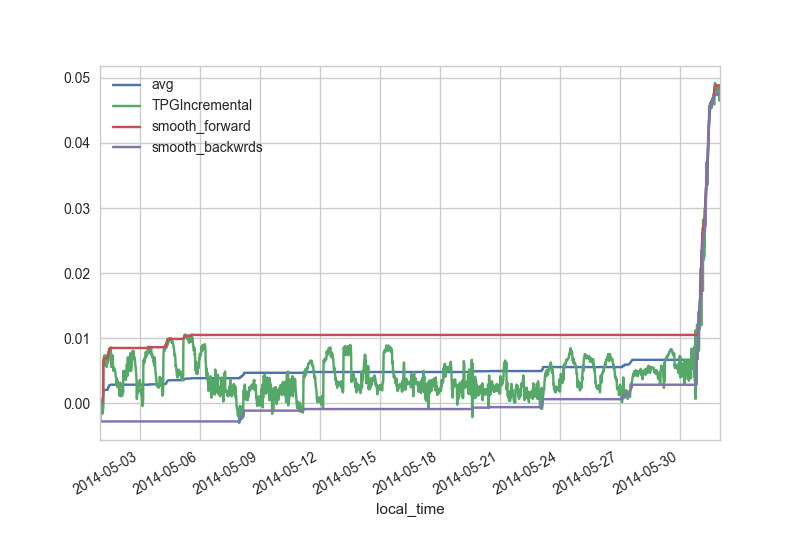

In [21]:
dat[['avg', 'TPGIncremental', 'smooth_forward', 'smooth_backwrds']].cumsum().plot()

<IPython.core.display.Javascript object>


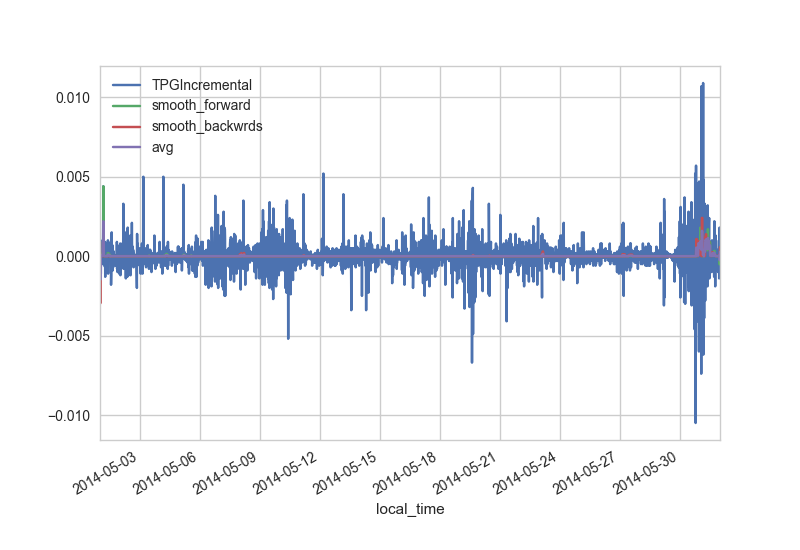

In [64]:
dat[['TPGIncremental', 'smooth_forward', 'smooth_backwrds', 'avg']].plot()

In [69]:
precip_smooth_Nayak2010(precip)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [70]:

precip=pd.DataFrame(precip)
precip_new=precip.copy()

# if precip[0]<0:
#     precip[1]=precip[1]+precip[0]
#     precip_new[0]=0 #force initial value to 0, if increment is negative

# if precip[1]<0:
#     if np.nansum(precip[0:3])<0:
#         precip_new[2]=(np.nansum(precip[0:3]))
#         precip_new[0]=0
#         precip_new[1]=0
#     else:
#         precip_new[0]=np.nansum(precip[0:3])/3
#         precip_new[1]=precip[0]
#         precip_new[2]=precip[0]

# precip[0:3]=precip_new[0:3] #set values in precip series to the values as edited above; necceary for smoothing
# #Smoothing Loop
# for ii in precip.index[3:]:
#     #if all NAN in the 5-sample window, skip to next iteration
#     if precip.iloc[ii-2:ii+3].isnull().all():
#         continue
#     if precip[ii]<0:
#         check=np.nansum(precip.iloc[ii-2:ii+3])/5
#         if check>=0: #if positive, precip[ii]= mean of 5 nearby values
#             precip_new.iloc[ii-2:ii+3]=np.nanmean(precip.iloc[ii-2:ii+3])
#         else:
#             precip_new.iloc[ii+2]=np.nansum(precip.iloc[ii-2:ii+3])
#             precip_new.iloc[ii-2:ii+2]=precip.iloc[ii-2]           

# return(precip_new)

In [65]:
#smooth_dat=pd.DataFrame(smooth_forward, smooth_backwards)
#smooth_mean=smooth_dat.mean(axis=0)

In [47]:
reverse_sorted_data=dat.TPGIncremental.copy() #avoid altering indexing of original series by making copy
reverse_sorted_data=pd.Series(reverse_sorted_data.values[::-1])
back3=LVL1.precip_smooth_Nayak2010(reverse_sorted_data)

In [58]:
reverse_sorted_data.values[::-1]

array([  0.00000000e+00,              nan,              nan, ...,
        -1.00000000e-04,   0.00000000e+00,   0.00000000e+00])

<IPython.core.display.Javascript object>


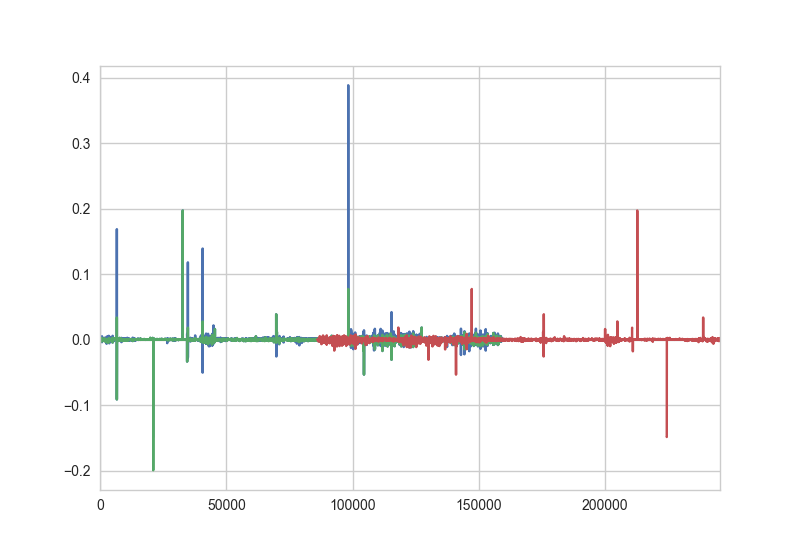

In [45]:
back2.plot()

In [16]:
#backwards data
backwards_data=dat.TPGIncremental.copy().iloc[::-1].reset_index(drop=True)

#smooth_backward=LVL1.precip_smooth_Nayak2010(dat.TPGIncremental.sort_index(ascending=False))

In [66]:
#smooth_backwrds=LVL1.precip_smooth_Nayak2010(reverse_sorted_data)

In [20]:
a=reversed(dat.TPGIncremental)

In [47]:
dat.TPGIncremental[dat.TPGIncremental<0]smooth_forward[smooth_forward<0]

local_time
2017-04-17 07:15:00-08:00   -0.0001
Name: TPGIncremental, dtype: float64

In [53]:
dat.TPGIncremental.sort_index(ascending=False).head()

local_time
2017-04-17 07:45:00-08:00    0.0000
2017-04-17 07:30:00-08:00    0.0000
2017-04-17 07:15:00-08:00   -0.0001
2017-04-17 07:00:00-08:00    0.0002
2017-04-17 06:45:00-08:00   -0.0001
Name: TPGIncremental, dtype: float64

In [ ]:
smooth

<IPython.core.display.Javascript object>


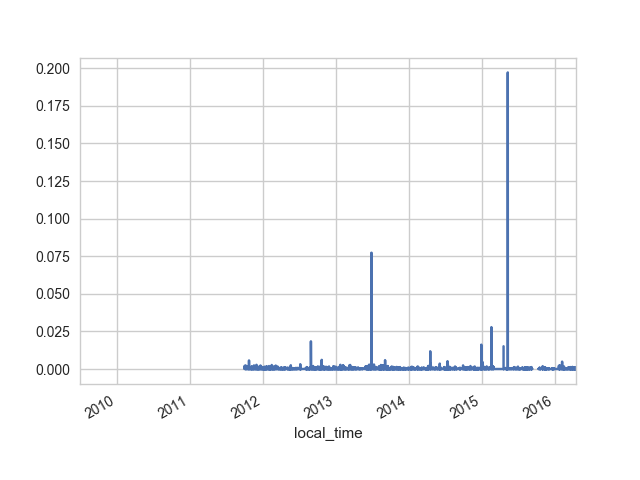

In [19]:
smooth_forward.plot()

In [151]:
ii=242395
precip=dat.TPGIncremental.copy()

print(precip.iloc[ii-2:ii+3])

precip.iloc[ii-2:ii+3]=np.nanmean(precip[ii-2:ii+3])

precip.iloc[ii-2:ii+3]

local_time
2017-03-17 01:30:00-08:00    0.0001
2017-03-17 01:45:00-08:00   -0.0008
2017-03-17 02:00:00-08:00    0.0018
2017-03-17 02:15:00-08:00   -0.0008
2017-03-17 02:30:00-08:00   -0.0020
Name: TPGIncremental, dtype: float64


local_time
2017-03-17 01:30:00-08:00   -0.00034
2017-03-17 01:45:00-08:00   -0.00034
2017-03-17 02:00:00-08:00   -0.00034
2017-03-17 02:15:00-08:00   -0.00034
2017-03-17 02:30:00-08:00   -0.00034
Name: TPGIncremental, dtype: float64

In [ ]:
#From Nayak2010
precip=dat.StageIncremental

#First 3 records must be >0: check progressively to ensure
#translated from Nayak 2010 thesis; slightly different than Shad's implementation in Matlab
if precip[0]<0:
    precip[1]=precip[1]+precip[0]
    precip[0]=0 #force initial value to 0, if increment is negative

if precip[1]<0:
    if np.nansum(precip[0:3])<0:
        precip[2]=(np.nansum(precip[0:3]))
        precip[0]=0
        precip[1]=0
    else:
        precip[0]=np.nansum(precip[0:3])/3
        precip[1]=precip[0]
        precip[2]=precip[0]
    

#Smoothing Loop
for ii in list(range(3,len(precip)-3)):
    if precip[ii]<0:
        check=np.nansum(precip[ii-2:ii+3])/5
        if check>=0: #if positive, precip[ii]= mean of 5 nearby values
            precip[ii-2:ii+3]=np.nanmean(precip[ii-2:ii+3])
        else:
            precip[ii+2]=np.nansum(precip[ii-2:ii+3])
            precip[ii-2:ii+2]=0
            
        
        
        
#         if np.nansum(precip[ii-2:ii+3])<0:
#             precip[ii+2]=np.nansum(precip[ii-2:ii+3])
#             precip[ii-2]=0
#             precip[ii-1]=0
#             precip[ii]=0
#             precip[ii+1]=0
#         else:
#             precip[ii-2]=np.nanmean(precip[ii-2:ii+3])
#             precip[ii-1]=precip[ii-2]
#             precip[ii]=precip[ii-2]
#             precip[ii+1]=precip[ii-2]
#             precip[ii+2]=precip[ii-2]


In [127]:
check=np.nansum(precip[ii-2:ii+3])/5
check

3.0

In [123]:
print(ii)
precip

3


[1, 2, 3, -1, 5, 6, 7, 8]

<IPython.core.display.Javascript object>


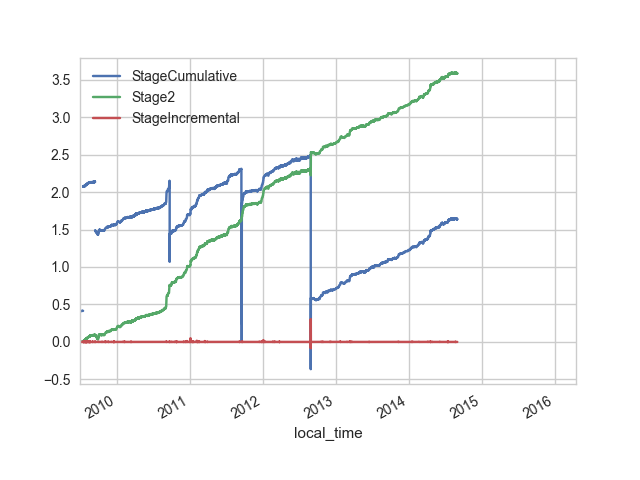

In [80]:
dat[['StageCumulative', 'Stage2', 'StageIncremental']].plot()

In [67]:
#dat['done_with_hampel_filter']=LVL1.hampel([dat.TPGCumulative.values], k=6)[0].tolist() #my function returning strange array

In [38]:
pd.options.mode.chained_assignment='warn'

In [34]:
dat.tail()

,Station,UTC_time,AK_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,RelHum,StageCumulative,TPGCumulative,WindSpeed,WindGustSpeed,WindDir,LoggerTemp,LoggerBattery,time,done_with_hampel_filter
local_time,,,,,,,,,,,,,,,,,
2017-04-17 06:45:00-08:00,wolverine_990,2017/04/17 06:45,2017/04/16 22:45,13.4,NaN,NaN,NaN,89.0,NaN,0.7462,6.5,9.1,86.0,-0.2,13.0,2017-04-17 06:45:00,0.7462
2017-04-17 07:00:00-08:00,wolverine_990,2017/04/17 07:00,2017/04/16 23:00,13.4,NaN,-3.66,-3.7,86.0,NaN,0.7464,5.2,7.8,86.0,-0.7,13.0,2017-04-17 07:00:00,0.7464
2017-04-17 07:15:00-08:00,wolverine_990,2017/04/17 07:15,2017/04/16 23:15,13.6,NaN,NaN,NaN,84.0,NaN,0.7463,4.3,6.5,93.0,-1.3,13.0,2017-04-17 07:15:00,0.7463
2017-04-17 07:30:00-08:00,wolverine_990,2017/04/17 07:30,2017/04/16 23:30,13.4,NaN,NaN,NaN,83.0,NaN,0.7463,5.1,9.3,79.0,-1.6,13.0,2017-04-17 07:30:00,0.7463
2017-04-17 07:45:00-08:00,wolverine_990,2017/04/17 07:45,2017/04/16 23:45,13.3,NaN,NaN,NaN,89.0,NaN,0.7463,4.7,6.7,79.0,-1.8,12.9,2017-04-17 07:45:00,0.7463


In [16]:
dat_original_saveToCompare.to_csv("DatatoUse Separate.csv")

In [17]:
pwd

'C:\\Users\\ehbaker\\Documents\\Python\\LocalScripts'

In [71]:
%qtconsole

In [28]:
dat.StageCumulative.dropna()

local_time
2010-07-01 08:45:00-08:00    0.4096
2010-07-01 09:00:00-08:00    0.4096
2010-07-01 09:15:00-08:00    0.4095
2010-07-01 09:30:00-08:00    0.4095
2010-07-01 09:45:00-08:00    0.4095
2010-07-01 10:00:00-08:00    0.4095
2010-07-01 10:15:00-08:00    0.4095
2010-07-01 10:30:00-08:00    0.4095
2010-07-01 10:45:00-08:00    0.4094
2010-07-01 11:00:00-08:00    0.4094
2010-07-01 11:15:00-08:00    0.4094
2010-07-01 11:30:00-08:00    0.4094
2010-07-01 11:45:00-08:00    0.4094
2010-07-01 12:00:00-08:00    0.4094
2010-07-01 12:15:00-08:00    0.4093
2010-07-01 12:30:00-08:00    0.4093
2010-07-01 12:45:00-08:00    0.4093
2010-07-01 13:00:00-08:00    0.4093
2010-07-01 13:15:00-08:00    0.4093
2010-07-01 13:30:00-08:00    0.4093
2010-07-01 13:45:00-08:00    0.4093
2010-07-01 14:00:00-08:00    0.4092
2010-07-01 14:15:00-08:00    0.4092
2010-07-01 14:30:00-08:00    0.4092
2010-07-01 14:45:00-08:00    0.4092
2010-07-01 15:00:00-08:00    0.4092
2010-07-01 15:15:00-08:00    0.4092
2010-07-01 15:30:

<IPython.core.display.Javascript object>


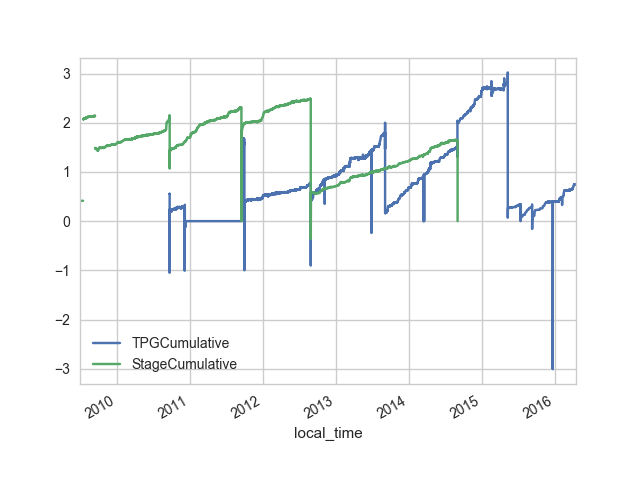

In [30]:
dat[precip_columns].plot()

In [46]:
dPrecip='TPGCumulative'

In [19]:
dat.head()

,Station,UTC_time,AK_time,Tpassive1,Tpassive2,TAspirated1,TAspirated2,RelHum,StageCumulative,TPGCumulative,WindSpeed,WindGustSpeed,WindDir,LoggerTemp,LoggerBattery,time,TPGIncremental,"(0, TPGCumulative)"
local_time,,,,,,,,,,,,,,,,,,
2010-07-01 08:45:00-08:00,wolverine_990,2010/07/01 08:45,2010/07/01 00:45,4.3,3.9,NaN,NaN,NaN,0.4096,NaN,3.3,4.2,NaN,NaN,NaN,2010-07-01 08:45:00,NaN,0
2010-07-01 09:00:00-08:00,wolverine_990,2010/07/01 09:00,2010/07/01 01:00,4.3,3.9,4.4,NaN,NaN,0.4096,NaN,3.6,4.4,NaN,NaN,NaN,2010-07-01 09:00:00,NaN,0
2010-07-01 09:15:00-08:00,wolverine_990,2010/07/01 09:15,2010/07/01 01:15,4.3,3.9,NaN,NaN,NaN,0.4095,NaN,3.1,4.0,NaN,NaN,NaN,2010-07-01 09:15:00,NaN,0
2010-07-01 09:30:00-08:00,wolverine_990,2010/07/01 09:30,2010/07/01 01:30,4.3,3.9,NaN,NaN,NaN,0.4095,NaN,3.1,4.2,NaN,NaN,NaN,2010-07-01 09:30:00,NaN,0
2010-07-01 09:45:00-08:00,wolverine_990,2010/07/01 09:45,2010/07/01 01:45,4.2,3.8,NaN,NaN,NaN,0.4095,NaN,3.1,4.2,NaN,NaN,NaN,2010-07-01 09:45:00,NaN,0


In [31]:
dat.ix[0,dPrecip]=0

In [33]:
dat.ix[0,dPrecip]

0.0